In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import torch

In [2]:
train_setting = "wd=0.0_lr=5e-5"

In [3]:
# === Configs ===
results_dir = "./results"
total_params = 123_532_032
num_layers = 48
methods = ["Localize-16*16", "Localize-32*32", "Localize-64*64",
           "Random Drop-0.93", "Random Drop-0.95", "Random Drop-0.97", "Random Drop-0.99",
           "LoGra-16*16", "LoGra-32*32", "LoGra-64*64"]
result_file = ["GC/IF-RAW/Linear/Localize-16*16_thrd-0.0_rdp-0.0.pt", "GC/IF-RAW/Linear/Localize-32*32_thrd-0.0_rdp-0.0.pt", "GC/IF-RAW/Linear/Localize-64*64_thrd-0.0_rdp-0.0.pt",
               "GC/IF-RAW/Linear/Identity-64*64_thrd-0.0_rdp-0.93.pt", "GC/IF-RAW/Linear/Identity-64*64_thrd-0.0_rdp-0.95.pt", "GC/IF-RAW/Linear/Identity-64*64_thrd-0.0_rdp-0.97.pt", "GC/IF-RAW/Linear/Identity-64*64_thrd-0.0_rdp-0.99.pt",
               "LoGra/IF-RAW/Linear/Random-16*16_thrd-0.0_rdp-0.0.pt", "LoGra/IF-RAW/Linear/Random-32*32_thrd-0.0_rdp-0.0.pt", "LoGra/IF-RAW/Linear/Random-64*64_thrd-0.0_rdp-0.0.pt"]

# Updated legend names
group_display_names = {
    "Localize": "Optimized Mask",
    "Random Drop": "Random Mask",
    "LoGra": "Random Projection"
}

group_colors = {
    "Localize": "dodgerblue",
    "Random Drop": "orange",
    "LoGra": "limegreen"
}

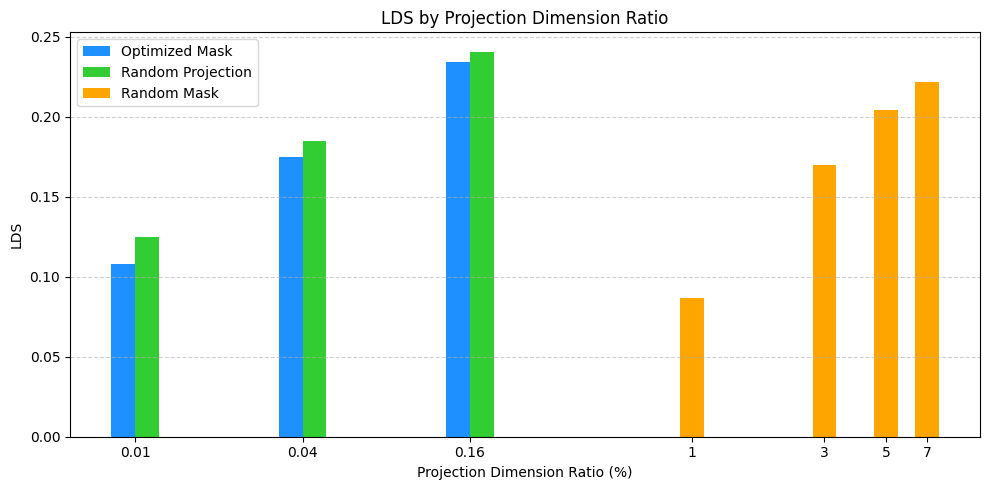

In [ ]:
# === Step 1: Collect LDS results ===
data_by_ratio = defaultdict(dict)
for idx, method in enumerate(methods):
    filename = os.path.join(results_dir, train_setting, result_file[idx])
    # Determine group and projection ratio
    if "Localize" in method:
        group = "Localize"
        dim = int(method.split("-")[1].split("*")[0])
        ratio = (num_layers * dim * dim) / total_params
    elif "LoGra" in method:
        group = "LoGra"
        dim = int(method.split("-")[1].split("*")[0])
        ratio = (num_layers * dim * dim) / total_params
    elif "Random Drop" in method:
        group = "Random Drop"
        drop_rate = float(method.split("-")[1])
        ratio = 1 - drop_rate
    else:
        continue
    if os.path.exists(filename):
        data = torch.load(filename, weights_only=False)
        lds = data.get("lds", None)
        if lds is not None:
            data_by_ratio[ratio][group] = lds
        else:
            print(f"Warning: 'lds' not found in {filename}")
    else:
        print(f"Warning: File not found: {filename}")

# === Step 2: Sort ratios and prepare plotting ===
ratios = sorted(data_by_ratio.keys())

# Create positions on x-axis based on log scale
log_ratios = [math.log10(r) for r in ratios]
min_log = min(log_ratios)
max_log = max(log_ratios)
# Normalize to get evenly spaced positions based on log scale
normalized_positions = [(lr - min_log) / (max_log - min_log) * (len(ratios) - 1) for lr in log_ratios]
x = np.array(normalized_positions)

bar_width = 0.18
plt.figure(figsize=(10, 5))
legend_shown = set()

for i, ratio in enumerate(ratios):
    groups = list(data_by_ratio[ratio].keys())
    num_groups = len(groups)
    start = x[i] - (num_groups - 1) * bar_width / 2
    for j, group in enumerate(groups):
        lds = data_by_ratio[ratio][group]
        xpos = start + j * bar_width
        # Use the display name for the legend instead of the internal group name
        label = group_display_names[group] if group not in legend_shown else None
        plt.bar(xpos, lds, width=bar_width, color=group_colors[group], label=label)
        legend_shown.add(group)

# === Styling ===
# Convert ratios to percentages for display with simplified formatting
percentage_labels = []

for r in ratios:
    if r < 0.01:
        percentage_labels.append(f"{r*100:.2f}")
    elif r < 0.1:
        percentage_labels.append(f"{round(r*100)}")

plt.xticks(x, percentage_labels)
plt.xlabel("Projection Dimension Ratio (%)")
plt.ylabel("LDS")
plt.title("LDS by Projection Dimension Ratio")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()